Ramas, Ron Patrick G.\
Daganta, Reynat A.

## **Assignment 2 in Data Analytics**

---

###  **Import Libraries**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

In [ ]:
library(AdhereR)

data <- med.events.ATC

head(data)

,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2
,<dbl>,<date>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,2057-09-04,28.00000,20,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
2,1,2058-06-03,28.00000,20,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
3,1,2058-07-09,28.00000,20,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
15,1,2056-10-09,41.66667,36000,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"
16,1,2056-12-10,40.00000,36000,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"
17,1,2057-02-12,11.00000,36000,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"


In [ ]:
write.csv(data, "med_events_ATC.csv", row.names = FALSE)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (1701438312.py, line 1)

In [56]:
# Example: load your data into a DataFrame called 'tidy'
# Assume tidy has the columns: "pnr", "eksd", "perday", "ATC", "dur_original"
# and that the date column 'eksd' is in month-day-year format.
# For example:
tidy = pd.read_csv("med_events_ATC.csv")
tidy.rename(columns={
    "PATIENT_ID": "pnr",
    "DATE": "eksd",
    "DURATION": "dur_original",
    "PERDAY": "perday",
    "CATEGORY": "ATC"
}, inplace=True)
# Convert the DATE column to datetime format (adjust format as needed)
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%Y-%m-%d')


### **ATC Codes**

In [ ]:
print(tidy['ATC'].unique())

['A02BC02' 'A09AA02' 'R03AC12' 'A11CC05' 'R03AK07' 'A05AA02' 'A11CA01'
 'A11HA03' 'A12AX' 'B02BA01' 'J01AA08' 'J01EE01' 'J01FA10' 'J01GB01'
 'J01MA02' 'J01XB01' 'J02AC02' 'R03AK08' 'R05CB13' 'R03BA05' 'A10AB05'
 'A10AE04' 'J01CR02' 'A02BC05' 'A10AD05' 'J02AC03' 'R03AC02' 'R03AK06'
 'R03AL04' 'R03DC03' 'J02AC04' 'R03DX05' 'A02BC01' 'A11CC01' 'J01DF01'
 'A10BX02' 'J01FG01' 'J01DD13']


### **Density**

In [ ]:
print(tidy['ATC'].value_counts())

ATC
A09AA02    251
A11HA03    160
J01FA10    119
A11CC05    107
A02BC05     78
R05CB13     76
A05AA02     75
B02BA01     74
R03AC02     64
J01XB01     63
J02AC02     62
J01EE01     41
R03AK06     40
A02BC01     38
J01GB01     33
R03DC03     32
R03AK07     30
A11CA01     26
J01MA02     26
R03AC12     23
A10BX02     20
R03DX05     19
J01AA08     19
A10AB05     18
A10AE04     17
J01DF01     12
A12AX       10
R03BA05      7
J01DD13      4
J01FG01      4
A02BC02      3
R03AK08      3
J02AC03      3
J01CR02      2
A10AD05      2
R03AL04      1
A11CC01      1
J02AC04      1
Name: count, dtype: int64


### **Sessa Empirator Estimator using K-Means**

C:\Users\ronpa\AppData\Local\Temp\ipykernel_11568\1914289458.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


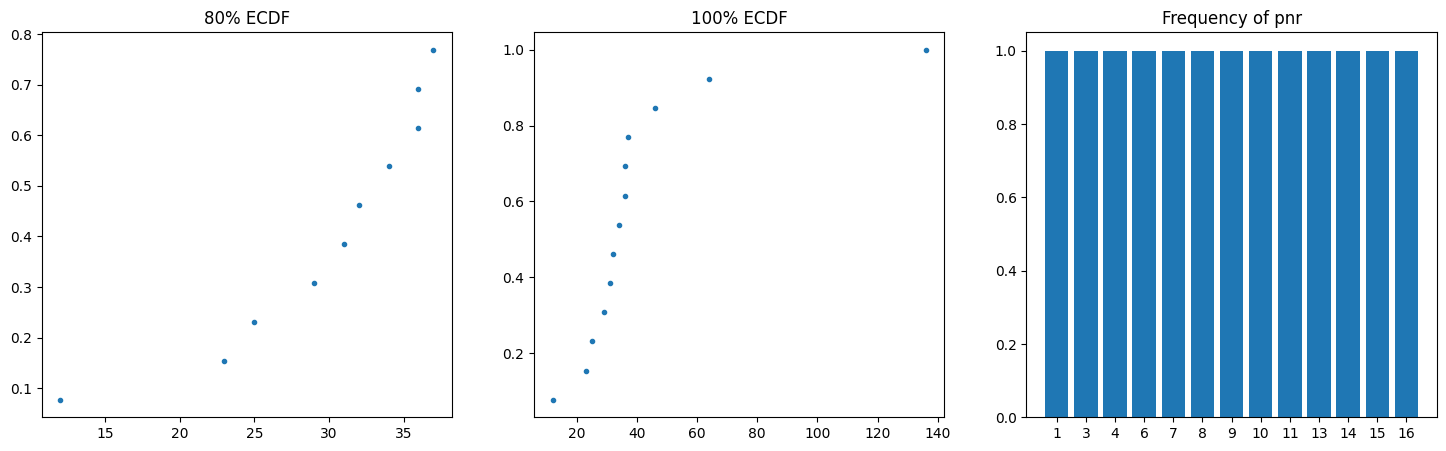

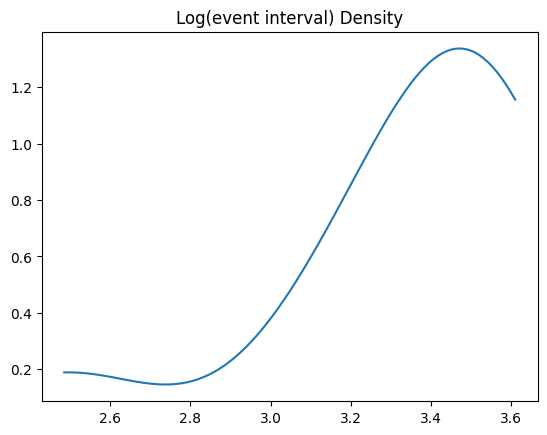

Optimal number of clusters (via silhouette): 2


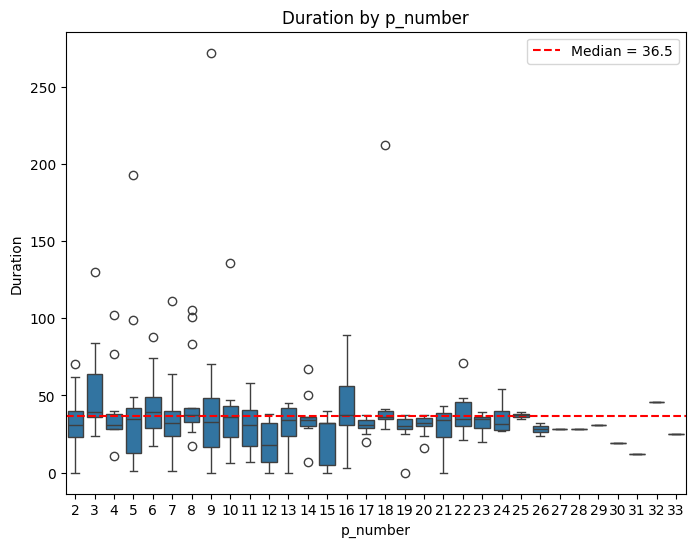

In [66]:
#%% [code]
def see(atc_code, tidy):
    # Filter for the chosen drug (ATC code)
    C09CA01 = tidy[tidy['ATC'] == atc_code].copy()
    # Make a copy to later merge back
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    # Sort by patient (pnr) and date (eksd)
    Drug_see_p1 = Drug_see_p1.sort_values(['pnr', 'eksd'])
    # Create a column with the previous date for each patient
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    # Remove the first event for each patient (NA in prev_eksd)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # For each patient, randomly sample one record (using a fixed random_state for reproducibility)
    Drug_see_p1 = (Drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=42))
                   .reset_index(drop=True))
    # Keep only the needed columns
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    
    # Compute event interval (in days) between successive events
    Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # --- ECDF Computation ---
    sorted_intervals = np.sort(Drug_see_p1['event_interval'].values)
    n = len(sorted_intervals)
    ecdf_y = np.arange(1, n+1) / n
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': ecdf_y})
    # Only consider the part of the ECDF up to 80%
    dfper_80 = dfper[dfper['y'] <= 0.8]
    ni = dfper_80['x'].max()
    
    # Plot the 80% and 100% ECDFs plus a bar plot of patient frequencies
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
    axs[0].set_title('80% ECDF')
    axs[1].plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
    axs[1].set_title('100% ECDF')
    m1 = Drug_see_p1['pnr'].value_counts()
    axs[2].bar(m1.index.astype(str), m1.values)
    axs[2].set_title('Frequency of pnr')
    plt.show()
    
    # --- Density Estimation on Log(Event Interval) ---
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event_interval'] <= ni].copy()
    log_intervals = np.log(Drug_see_p2['event_interval'].values)
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    plt.figure()
    plt.plot(x1, y1)
    plt.title('Log(event interval) Density')
    plt.show()
    
    # Create a DataFrame from the density estimates and scale it
    a = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    
    # --- Determine Optimal Number of Clusters via Silhouette Analysis ---
    silhouette_scores = {}
    for k in range(2, min(10, len(a_scaled)) + 1):
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        silhouette_scores[k] = score
    if silhouette_scores:
        max_cluster = max(silhouette_scores, key=silhouette_scores.get)
    else:
        max_cluster = 1
    print("Optimal number of clusters (via silhouette):", max_cluster)
    
    # --- K-Means Clustering on the ECDF x-values ---
    km_final = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = km_final.fit_predict(dfper[['x']])
    
    # Compute cluster-wise summaries on log(x)
    dfper['log_x'] = np.log(dfper['x'])
    cluster_stats = (dfper.groupby('cluster')['log_x']
                     .agg(['min', 'max', 'median'])
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max'])
    cluster_stats['Median'] = np.exp(cluster_stats['median'])
    cluster_stats = cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']]
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    # --- Assign Clusters via a Cross Join ---
    results = Drug_see_p1.merge(cluster_stats, how='cross')
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['Minimum']) & 
        (results['event_interval'] <= results['Maximum']),
        results['cluster'],
        np.nan
    )
    results = results.dropna(subset=['Final_cluster'])
    results['Final_cluster'] = results['Final_cluster'].astype(int)
    
    # Determine the most frequent cluster among these assignments
    most_freq_cluster = results['Final_cluster'].value_counts().idxmax()
    median_value = cluster_stats.loc[cluster_stats['cluster'] == most_freq_cluster, 'Median'].values[0]
    
    # Merge the results (per patient) back into Drug_see_p1
    results_subset = results[['pnr', 'Median', 'Final_cluster']].drop_duplicates(subset=['pnr'])
    Drug_see_p1 = pd.merge(Drug_see_p1, results_subset, on='pnr', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(median_value)
    Drug_see_p1['Final_cluster'] = Drug_see_p1['Final_cluster'].fillna(0).astype(int)
    Drug_see_p1['test'] = np.round(Drug_see_p1['event_interval'] - Drug_see_p1['Median'], 1)
    
    # --- Prepare Final Output ---
    results_final = pd.merge(Drug_see_p0, 
                             Drug_see_p1[['pnr', 'Median', 'Final_cluster']], 
                             on='pnr', how='left')
    results_final['Median'] = results_final['Median'].fillna(median_value)
    results_final['Final_cluster'] = results_final['Final_cluster'].fillna(0).astype(int)
    
    return results_final

#%% [code]
def see_assumption(df):
    df_sorted = df.sort_values(['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
    df_filtered = df_sorted[df_sorted['p_number'] >= 2].copy()
    df_filtered['Duration'] = (df_filtered['eksd'] - df_filtered['prev_eksd']).dt.days
    medians_of_medians = df_filtered.groupby('pnr')['Duration'].median().reset_index(name='median_duration')
    overall_median = medians_of_medians['median_duration'].median()
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_filtered)
    plt.axhline(overall_median, color='red', linestyle='--', label=f'Median = {overall_median}')
    plt.title('Duration by p_number')
    plt.legend()
    plt.show()
    
    return

#%% [code]
medA = see("A09AA02", tidy)
# medB = see("A11HA03", tidy)

see_assumption(medA)
# see_assumption(medB)